In [1]:
%matplotlib inline
from shifts import *
from periods import *
from image_loading import *
from drift_correction import *
from shifts_global_solution import *
from tqdm import *
import importlib
import matplotlib.image as img
import plist_wrapper as jPlist

In [2]:
kNumSamplesPerPeriod = 60
path = '/Users/jonny/Movies/thursday_part_2/2016-06-09 16.37.35 vid slow heart belly scan/Brightfield - Prosilica'
format = '%s/%06d.tif'

# Load the images from disk (and determine the average period)
# Although the brightfield dataset goes on a few thousand frames after this,
# the focus correction went funny at the end of the run, and there is a massive 
# shift in the brightfield images. I don't want to include them, in case they 
# cause problems with the sync
firstImage = 54863
downsampling = 2
if False:
    numImagesToProcess = 10673
    (images, averagePeriod) = LoadImages(path, format, firstImage, numImagesToProcess, downsampleFactor=downsampling)
    #(im2, dummy) = LoadImages(path, format, 1, 13250, downsampleFactor=downsampling, frameIndexOffset=65535)
    #images = np.append(images, im2)
elif False:
    # Load two non-contiguous blocks of frames
    numImagesToProcess = 2000
    (images, averagePeriod) = LoadImages(path, format, firstImage, numImagesToProcess, downsampleFactor=downsampling)
    print("WARNING: temporary loading of another block of frames")
    (im2, dummy) = LoadImages(path, format, 1, 2000, downsampleFactor=downsampling, frameIndexOffset=images[-1].frameIndex)
    images = np.append(images, im2)
else:
    # Load just a small number of frames
    (images, averagePeriod) = LoadImages(path, format, firstImage, 800, downsampleFactor=downsampling)


loading images: 100%|██████████| 800/800 [00:17<00:00, 26.87it/s]

average period 30.7


/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


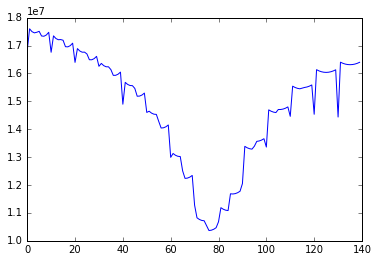

In [5]:
def ScorePeriodsForImageSequence2(images, k, periodRange, context='', delta=0.1):
    scores = []
    (minPeriod, maxPeriod) = periodRange
    periods = np.arange(minPeriod, maxPeriod, delta)
    for period in periods:
        scores = scores + [ScoreCandidatePeriod(images, period, k)]
    return (periods, np.array(scores))

def EstablishPeriodForImageSequence2(images, periodRange, context='', delta=0.1):
   # It seems that k=1e3 to 1e4 is the right ballpark, in that that's when the graph starts to change noticably.
   (periods, scores) = ScorePeriodsForImageSequence2(images, k=1000, periodRange=periodRange, context=context, delta=delta)
   return (periods[np.argmin(scores)], scores)

def SplitIntoSections2(images, averagePeriod, periodRange, delta=0.1):
   # Split up the sequence into sections of 2T+alpha in length
   # (discarding any remainder at the end of the sequence)
   alpha = 10
   sectionLength = 2 * averagePeriod + alpha
   imageSections = []
   sectionPeriods = []

   i = 0
   thisSection = images[i*sectionLength : min((i+1)*sectionLength, len(images))]
   (thisPeriod, theseScores) = EstablishPeriodForImageSequence2(thisSection, periodRange, delta)
   plt.plot(theseScores)

SplitIntoSections2(images, averagePeriod, periodRange=(23, 37), delta=0.02)

In [6]:
def EstablishPeriodForImageSequence2(images, periodRange, context=''):
    # It seems that k=1e3 to 1e4 is the right ballpark, in that that's when the graph starts to change noticably.
    (periods, scores) = ScorePeriodsForImageSequence(images, k=1000, periodRange=periodRange, context=context)
    return (periods[np.argmin(scores)], scores)

def SplitIntoSections2(images, averagePeriod, periodRange):
    # Split up the sequence into sections of 2T+alpha in length
    # (discarding any remainder at the end of the sequence)
    alpha = 10
    sectionLength = 2 * averagePeriod + alpha
    imageSections = []
    sectionPeriods = []
	
    i = 0
    thisSection = images[i*sectionLength : min((i+1)*sectionLength, len(images))]
    (thisPeriod, theseScores) = EstablishPeriodForImageSequence2(thisSection, periodRange)
    plt.plot(theseScores)

SplitIntoSections2(images, averagePeriod, periodRange=(23, 37))

In [3]:
# Looking at the scores when determining the period, there is a clear drop-off in score at higher values of period
# I suspect this is because if time-sequential frames are adjacent in the phase-wrapped version
# then the overall penalties are much lower (adjacent frames are more similar than frames one beat apart, due to RBCs etc)
# This means that our candidate period bracket cannot be too generous.
# For the "slow heart belly scan" dataset, a range of (20, 50) finds 50-ish for sequence 10, instead of 30ish.

(imageSections, sectionPeriods) = SplitIntoSections(images, averagePeriod, periodRange = (23, 37))

print('period range', np.min(sectionPeriods), 'to', np.max(sectionPeriods))
print (len(imageSections), 'image sections')
resampledImageSections = ResampleUniformly(imageSections, sectionPeriods, kNumSamplesPerPeriod)

resample, using 60 samples per period: 100%|██████████| 11/11 [00:00<00:00, 42.65it/s]

('section periods', [30.600000000000108, 30.600000000000108, 30.600000000000108, 30.600000000000108, 30.600000000000108, 30.600000000000108, 31.000000000000114, 31.000000000000114, 30.600000000000108, 30.600000000000108, 30.000000000000099])
('period range', 30.000000000000099, 'to', 31.000000000000114)
(11, 'image sections')
(' took', 0.25925612449645996)


In [13]:
if True:
    sequenceDrifts = CorrectForDrift(resampledImageSections, kNumSamplesPerPeriod)
else:
    sequenceDrifts = [(0, 0)] * len(resampledImageSections)

drift correction: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


In [14]:
shifts = GetShifts(resampledImageSections, sectionPeriods, sequenceDrifts, 10, kNumSamplesPerPeriod)

calculate sequence shifts: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

(' took', 11.179317951202393)


In [8]:
(globalShiftSolution, adjustedShifts, adjacentSolution, res, res2) = MakeShiftsSelfConsistent(shifts, len(resampledImageSections), kNumSamplesPerPeriod)

#print (globalShiftSolution - adjacentSolution)

if False:
    for i in range(len(shifts)):
        # Look at how each measured shift compares with the solution we obtained
        (i, j, sh, sc) = shifts[i]
        print(i, j, sh, sc, (globalShiftSolution[j]-globalShiftSolution[i])%kNumSamplesPerPeriod, (adjacentSolution[j]-adjacentSolution[i])%kNumSamplesPerPeriod)
    
# Look at how the global solution differs from the adjacent solution
# (bearing in mind that we don't necessarily know which one to trust!)
# Note that it would be informative to work with a long video that truly is 
# just focused on a single plane. That would help test how much the shifts
# will naturally wander due to random variation.
# sqrt(n) random walk would suggest wandering 17 in 300, which is about what I see, in fact.
# Another potentially interesting thing to do would be to do a z scan and then retreat
# back to where we started (if this can be done smoothly), and see how much the phase has drifted.
# Yet another would be to run the same analysis but with different resampling,
# and see how similar the results are.
#plt.plot(((adjacentSolution - globalShiftSolution + kNumSamplesPerPeriod/2.0) % kNumSamplesPerPeriod) - kNumSamplesPerPeriod/2.0)

#print (adjacentSolution[50:80] % kNumSamplesPerPeriod)
#print (globalShiftSolution[50:80] % kNumSamplesPerPeriod)
#print (((adjacentSolution - globalShiftSolution)[50:80]) % kNumSamplesPerPeriod)

In [9]:
from phase_assignment import *

# Define phases for resampled image sections
# These give our definitive known time/phase mapping
(knownTimes, knownPhases) = DefinePhaseForSequence(resampledImageSections, globalShiftSolution, kNumSamplesPerPeriod, plotIt = True)
# Fill in the phases on the original brightfield images (because why not)
(dummy1, dummy2) = DefinePhaseForSequence(imageSections, globalShiftSolution, kNumSamplesPerPeriod)


In [10]:
from annotation import *

basePath = '/Users/jonny/Movies/thursday_part_2/2016-06-09 16.37.35 vid slow heart belly scan'
AnnotateFluorChannel('%s/Red - QIClick Q35979' % basePath, knownTimes, knownPhases, earlyTruncation = 100)
    

edit plists: 100%|██████████| 100/100 [00:00<00:00, 520.64it/s]

(14, '/', 100, 'failed to recover a phase')
